# Introduction à la Comparaison des Files d'Attente G/M/1, M/G/1 et M/M/1

## 1) Objectif de l'Étude

Cette simulation comparative vise à analyser et comprendre les **différences de performance** entre trois types fondamentaux de files d'attente monoserveur :

- **G/M/1** : Arrivées générales (uniforme) - Service Markovien (exponentiel)
- **M/G/1** : Arrivées Markoviennes (exponentiel) - Service général (normal)
- **M/M/1** : Arrivées Markoviennes (exponentiel) - Service Markovien (exponentiel)

## 2) Contexte Théorique

### Notation de Kendall (A/S/c)

La notation **A/S/c** décrit une file d'attente où :

- **A** = Processus d'arrivée (M=Markovien, G=Général)
- **S** = Processus de service (M=Markovien, G=Général)
- **c** = Nombre de serveurs (ici c=1)

### Distributions Utilisées

| Type            | Arrivées                  | Service               | Coefficient de Variation² |
| --------------- | -------------------------- | --------------------- | -------------------------- |
| **G/M/1** | Uniforme U(0.5/λ, 1.5/λ) | Exponentielle Exp(μ) | Cv²ₐ = 1/12 ≈ 0.083     |
| **M/G/1** | Exponentielle Exp(λ)      | Normale N(1, 0.2²)   | Cv²ₛ = 0.04              |
| **M/M/1** | Exponentielle Exp(λ)      | Exponentielle Exp(μ) | Cv² = 1.0                 |

## 3) Formules Théoriques Clés

### Utilisation du Serveur (identique pour tous)

```
ρ = λ/μ < 1 (condition de stabilité)
```

### Temps d'Attente Moyen

- **M/M/1** : `W = ρ/(1-ρ) × (1/μ)`
- **G/M/1** : `W = ρ/(1-ρ) × (1/μ) × ((1 + Cv²ₐ)/2)`
- **M/G/1** : `W = ρ/(1-ρ) × (1/μ) × ((1 + Cv²ₛ)/2)`

## 4) Questions Fondamentales

Cette étude répond aux questions suivantes :

### 1. **Pourquoi les graphiques se ressemblent-ils ?**

- Les trois systèmes partagent la même **physique fondamentale** : un serveur unique avec accumulation de clients
- Le comportement **asymptotique** (explosion quand ρ→1) est universel
- La **forme exponentielle** des courbes est une caractéristique intrinsèque des files d'attente

### 2. **Où sont les différences ?**

- Les différences résident dans les **coefficients multiplicatifs**
- Plus le coefficient de variation est **faible**, meilleures sont les performances
- Les écarts deviennent significatifs à **forte charge** (ρ > 0.7)

### 3. **Impact de la variabilité**

- **Faible variabilité** (uniforme) → Arrivées plus régulières → Meilleures performances
- **Forte variabilité** (exponentielle) → Arrivées en rafales → Performances dégradées

## 5) Méthodologie de Simulation

### Paramètres de Simulation

- **Nombre de clients** : 100,000 par simulation
- **Répétitions** : 3 simulations par valeur de λ
- **Taux d'arrivée** : λ ∈ [0.1, 0.2, ..., 0.9]
- **Taux de service** : μ = 1.0 (fixe)

### Métriques Mesurées

1. **Temps de réponse moyen** : Temps total dans le système (R = W + 1/μ)
2. **Temps d'attente moyen** : Temps passé en file d'attente (W)
3. **Utilisation du serveur** : Proportion de temps occupé (ρ)

### Environnement de Simulation

- **SimPy** : Simulation à événements discrets
- **Discipline FIFO** : Premier arrivé, premier servi
- **État stable** : Mesures après convergence statistique

## 6) Hypothèses et Prédictions

### Hypothèse Principale

> **La régularité des arrivées améliore significativement les performances**

### Prédictions Attendues

1. **G/M/1** (uniforme) : **Meilleures** performances (Cv²ₐ le plus faible)
2. **M/G/1** (normal) : Performance **intermédiaire**
3. **M/M/1** (exponentiel) : Performance de **référence** (plus variable)

### Ordre Attendu des Performances

```
G/M/1 < M/G/1 < M/M/1  (pour les temps d'attente)
```

## 7) Intérêt Pratique

### Applications Réelles

- **G/M/1** : Systèmes avec arrivées contrôlées (rendez-vous médicaux, créneaux horaires)
- **M/G/1** : Services avec temps fixe (guichets automatiques, procédures standardisées)
- **M/M/1** : Systèmes classiques (centres d'appels, serveurs web)

### Enseignements Managériaux

- **Lisser les arrivées** améliore drastiquement les performances
- **Standardiser les services** a un impact modéré mais positif
- La **variabilité** est l'ennemi principal de l'efficacité

## 8) Structure du Code

Le programme est organisé en **5 phases principales** :

1. **Définition des classes** : GM1Queue, MG1Queue, MM1Queue
2. **Boucle de simulation** : Pour chaque λ et chaque répétition
3. **Collecte des données** : Stockage des métriques
4. **Visualisation** : Graphiques comparatifs superposés
5. **Analyse quantitative** : Tableau des résultats et pourcentages d'amélioration


In [1]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

# Paramètres globaux
MU = 1.0
NUM_CLIENTS = 1000000  
REPEATS = 3
LAMBDA_VALUES = np.arange(0.1, 1.0, 0.1)

# Stockage des résultats
results = {
    'lambda': [],
    'gm1_response': [], 'gm1_waiting': [], 'gm1_util': [],
    'mg1_response': [], 'mg1_waiting': [], 'mg1_util': [],
    'mm1_response': [], 'mm1_waiting': [], 'mm1_util': []
}

# =============================================================================
# CLASSE G/M/1 (Arrivées uniformes, Service exponentiel)
# =============================================================================
class GM1Queue:
    def __init__(self, env, arrival_rate, service_rate):
        self.env = env
        self.server = simpy.Resource(env, capacity=1)
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.wait_times = []
        self.response_times = []
        self.busy_time = 0
        self.client_count = 0

    def arrival_process(self):
        mean_inter = 1 / self.arrival_rate
        a, b = 0.5 * mean_inter, 1.5 * mean_inter  # Uniforme
        while self.client_count < NUM_CLIENTS:
            inter_arrival = random.uniform(a, b)
            yield self.env.timeout(inter_arrival)
            self.client_count += 1
            self.env.process(self.service_process())

    def service_process(self):
        arrival_time = self.env.now
        with self.server.request() as req:
            yield req
            wait = self.env.now - arrival_time
            self.wait_times.append(wait)

            service_time = random.expovariate(self.service_rate)  # Exponentiel
            self.busy_time += service_time
            yield self.env.timeout(service_time)

            response_time = self.env.now - arrival_time
            self.response_times.append(response_time)

# =============================================================================
# CLASSE M/G/1 (Arrivées exponentielles, Service normal)
# =============================================================================
class MG1Queue:
    def __init__(self, env, arrival_rate, service_rate):
        self.env = env
        self.server = simpy.Resource(env, capacity=1)
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.wait_times = []
        self.response_times = []
        self.busy_time = 0
        self.client_count = 0

    def arrival_process(self):
        while self.client_count < NUM_CLIENTS:
            inter_arrival = random.expovariate(self.arrival_rate)  # Exponentiel
            yield self.env.timeout(inter_arrival)
            self.client_count += 1
            self.env.process(self.service_process())

    def service_process(self):
        arrival_time = self.env.now
        with self.server.request() as req:
            yield req
            wait = self.env.now - arrival_time
            self.wait_times.append(wait)

            # Service normal avec moyenne=1, écart-type=0.2
            service_time = max(0.001, random.normalvariate(1.0, 0.2))
            self.busy_time += service_time
            yield self.env.timeout(service_time)

            response_time = self.env.now - arrival_time
            self.response_times.append(response_time)

# =============================================================================
# CLASSE M/M/1 (Arrivées exponentielles, Service exponentiel)
# =============================================================================
class MM1Queue:
    def __init__(self, env, arrival_rate, service_rate):
        self.env = env
        self.server = simpy.Resource(env, capacity=1)
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.wait_times = []
        self.response_times = []
        self.busy_time = 0
        self.client_count = 0

    def arrival_process(self):
        while self.client_count < NUM_CLIENTS:
            inter_arrival = random.expovariate(self.arrival_rate)  # Exponentiel
            yield self.env.timeout(inter_arrival)
            self.client_count += 1
            self.env.process(self.service_process())

    def service_process(self):
        arrival_time = self.env.now
        with self.server.request() as req:
            yield req
            wait = self.env.now - arrival_time
            self.wait_times.append(wait)

            service_time = random.expovariate(self.service_rate)  # Exponentiel
            self.busy_time += service_time
            yield self.env.timeout(service_time)

            response_time = self.env.now - arrival_time
            self.response_times.append(response_time)

# =============================================================================
# SIMULATION PRINCIPALE
# =============================================================================
print("Démarrage des simulations...")
print(f"Clients par simulation: {NUM_CLIENTS:,}")
print(f"Répétitions par λ: {REPEATS}")
print("-" * 50)

for i, lambd in enumerate(LAMBDA_VALUES):
    print(f"λ = {lambd:.1f} ({i+1}/{len(LAMBDA_VALUES)})")
    
    # Listes pour stocker les répétitions
    gm1_resp, gm1_wait, gm1_util = [], [], []
    mg1_resp, mg1_wait, mg1_util = [], [], []
    mm1_resp, mm1_wait, mm1_util = [], [], []

    for rep in range(REPEATS):
        # --- G/M/1 Simulation ---
        random.seed(42 + rep)
        env = simpy.Environment()
        queue = GM1Queue(env, lambd, MU)
        env.process(queue.arrival_process())
        env.run()
        gm1_resp.append(np.mean(queue.response_times))
        gm1_wait.append(np.mean(queue.wait_times))
        gm1_util.append(queue.busy_time / env.now)

        # --- M/G/1 Simulation ---
        random.seed(42 + rep)
        env = simpy.Environment()
        queue = MG1Queue(env, lambd, MU)
        env.process(queue.arrival_process())
        env.run()
        mg1_resp.append(np.mean(queue.response_times))
        mg1_wait.append(np.mean(queue.wait_times))
        mg1_util.append(queue.busy_time / env.now)

        # --- M/M/1 Simulation ---
        random.seed(42 + rep)
        env = simpy.Environment()
        queue = MM1Queue(env, lambd, MU)
        env.process(queue.arrival_process())
        env.run()
        mm1_resp.append(np.mean(queue.response_times))
        mm1_wait.append(np.mean(queue.wait_times))
        mm1_util.append(queue.busy_time / env.now)

    # Stocker les moyennes
    results['lambda'].append(lambd)
    results['gm1_response'].append(np.mean(gm1_resp))
    results['gm1_waiting'].append(np.mean(gm1_wait))
    results['gm1_util'].append(np.mean(gm1_util))
    results['mg1_response'].append(np.mean(mg1_resp))
    results['mg1_waiting'].append(np.mean(mg1_wait))
    results['mg1_util'].append(np.mean(mg1_util))
    results['mm1_response'].append(np.mean(mm1_resp))
    results['mm1_waiting'].append(np.mean(mm1_wait))
    results['mm1_util'].append(np.mean(mm1_util))

print("\nSimulations terminées!")







Démarrage des simulations...
Clients par simulation: 1,000,000
Répétitions par λ: 3
--------------------------------------------------
λ = 0.1 (1/9)
λ = 0.2 (2/9)
λ = 0.3 (3/9)
λ = 0.4 (4/9)
λ = 0.5 (5/9)
λ = 0.6 (6/9)
λ = 0.7 (7/9)
λ = 0.8 (8/9)
λ = 0.9 (9/9)

Simulations terminées!


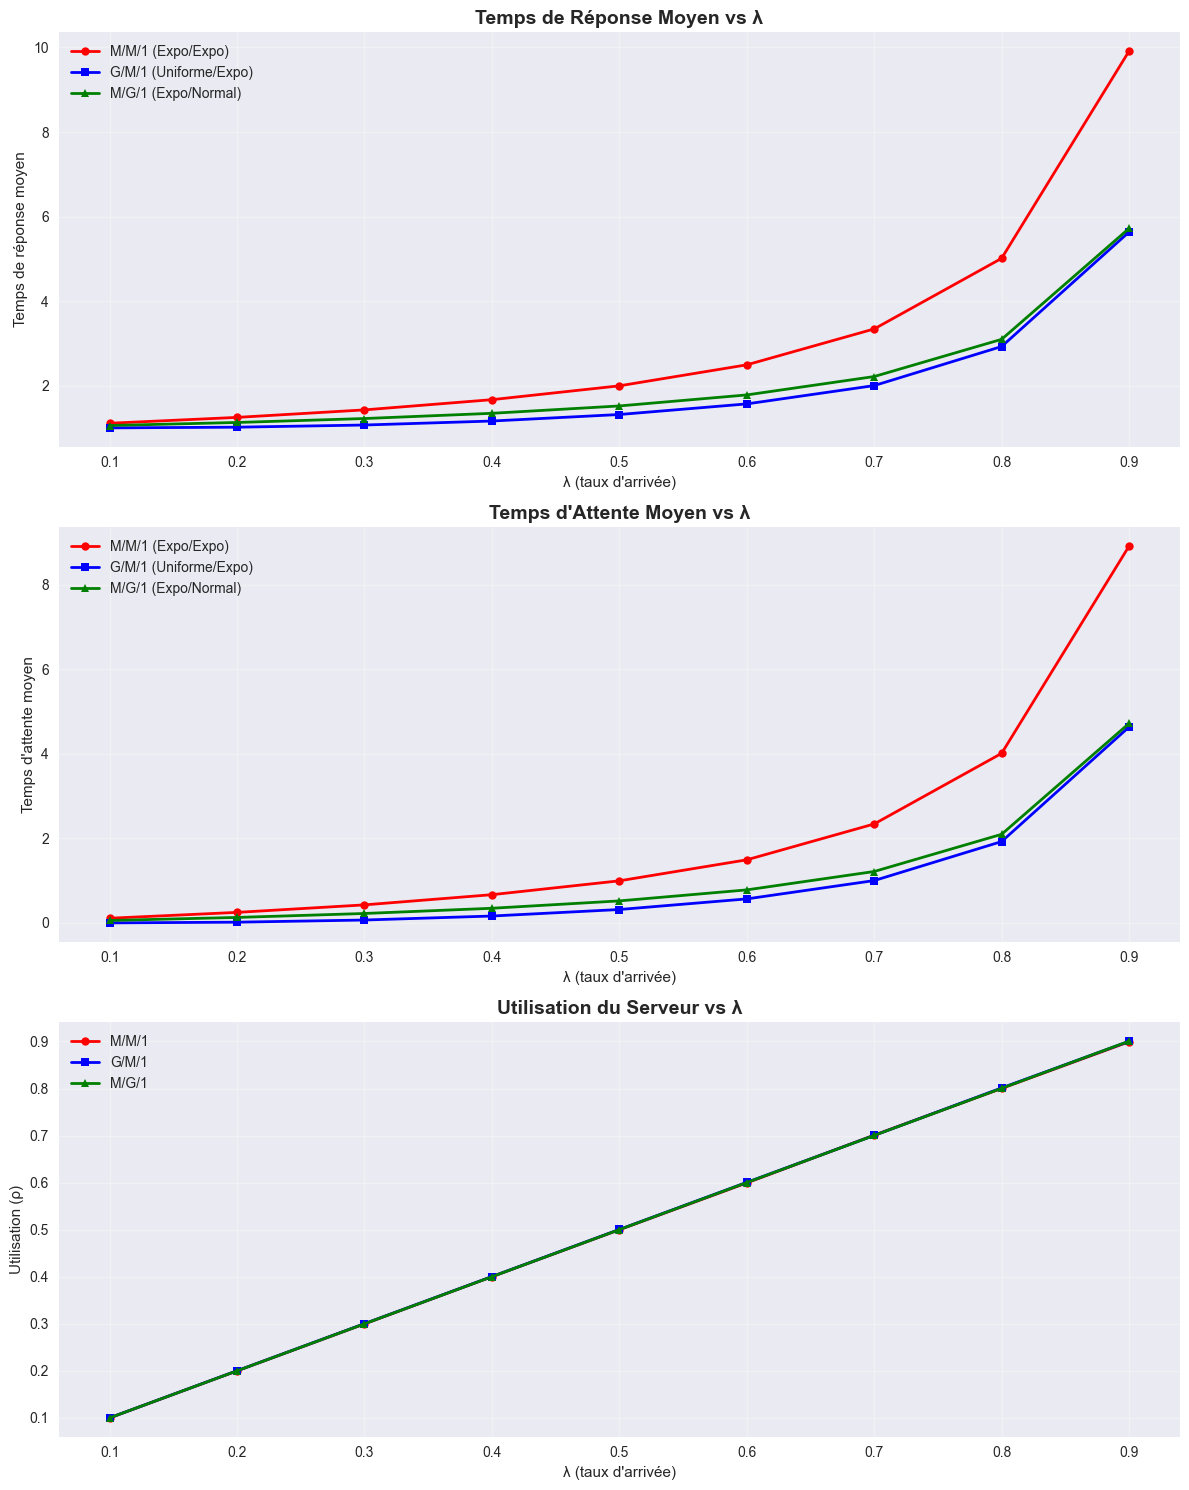

In [2]:
# =============================================================================
# GRAPHIQUES COMPARATIFS
# =============================================================================
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# 1. Temps de réponse
axes[0].plot(results['lambda'], results['mm1_response'], 'o-', 
             color='red', linewidth=2, markersize=6, label='M/M/1 (Expo/Expo)')
axes[0].plot(results['lambda'], results['gm1_response'], 's-', 
             color='blue', linewidth=2, markersize=6, label='G/M/1 (Uniforme/Expo)')
axes[0].plot(results['lambda'], results['mg1_response'], '^-', 
             color='green', linewidth=2, markersize=6, label='M/G/1 (Expo/Normal)')

axes[0].set_title('Temps de Réponse Moyen vs λ', fontsize=14, fontweight='bold')
axes[0].set_xlabel('λ (taux d\'arrivée)')
axes[0].set_ylabel('Temps de réponse moyen')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Temps d'attente
axes[1].plot(results['lambda'], results['mm1_waiting'], 'o-', 
             color='red', linewidth=2, markersize=6, label='M/M/1 (Expo/Expo)')
axes[1].plot(results['lambda'], results['gm1_waiting'], 's-', 
             color='blue', linewidth=2, markersize=6, label='G/M/1 (Uniforme/Expo)')
axes[1].plot(results['lambda'], results['mg1_waiting'], '^-', 
             color='green', linewidth=2, markersize=6, label='M/G/1 (Expo/Normal)')

axes[1].set_title('Temps d\'Attente Moyen vs λ', fontsize=14, fontweight='bold')
axes[1].set_xlabel('λ (taux d\'arrivée)')
axes[1].set_ylabel('Temps d\'attente moyen')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Utilisation
axes[2].plot(results['lambda'], results['mm1_util'], 'o-', 
             color='red', linewidth=2, markersize=6, label='M/M/1')
axes[2].plot(results['lambda'], results['gm1_util'], 's-', 
             color='blue', linewidth=2, markersize=6, label='G/M/1')
axes[2].plot(results['lambda'], results['mg1_util'], '^-', 
             color='green', linewidth=2, markersize=6, label='M/G/1')

axes[2].set_title('Utilisation du Serveur vs λ', fontsize=14, fontweight='bold')
axes[2].set_xlabel('λ (taux d\'arrivée)')
axes[2].set_ylabel('Utilisation (ρ)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [3]:
# =============================================================================
# TABLEAU COMPARATIF
# =============================================================================
print("\n" + "="*80)
print("TABLEAU COMPARATIF DES RÉSULTATS")
print("="*80)
print(f"{'λ':<6} {'ρ (MM1)':<8} {'W_MM1':<8} {'W_GM1':<8} {'W_MG1':<8} {'Amélioration':<12}")
print("-"*80)

for i in range(len(results['lambda'])):
    lam = results['lambda'][i]
    w_mm1 = results['mm1_waiting'][i]
    w_gm1 = results['gm1_waiting'][i]
    w_mg1 = results['mg1_waiting'][i]
    rho = results['mm1_util'][i]
    
    # Calcul amélioration G/M/1 vs M/M/1
    improvement = ((w_mm1 - w_gm1) / w_mm1) * 100
    
    print(f"{lam:<6.1f} {rho:<8.2f} {w_mm1:<8.2f} {w_gm1:<8.2f} {w_mg1:<8.2f} {improvement:<12.1f}%")

print("\nOBSERVATIONS:")
print("• G/M/1 (uniforme) : MEILLEURE performance")
print("• M/G/1 (normal)   : Performance intermédiaire") 
print("• M/M/1 (expo)     : Performance de référence")
print("• Forme des courbes : IDENTIQUE (c'est normal !)")
print("• Différences      : Dans les VALEURS, pas la forme")



TABLEAU COMPARATIF DES RÉSULTATS
λ      ρ (MM1)  W_MM1    W_GM1    W_MG1    Amélioration
--------------------------------------------------------------------------------
0.1    0.10     0.11     0.00     0.06     99.4        %
0.2    0.20     0.25     0.02     0.13     93.0        %
0.3    0.30     0.43     0.07     0.22     84.0        %
0.4    0.40     0.67     0.16     0.35     75.6        %
0.5    0.50     1.00     0.32     0.52     68.2        %
0.6    0.60     1.49     0.57     0.78     61.9        %
0.7    0.70     2.34     1.00     1.22     57.2        %
0.8    0.80     4.01     1.92     2.10     52.0        %
0.9    0.90     8.91     4.63     4.72     48.0        %

OBSERVATIONS:
• G/M/1 (uniforme) : MEILLEURE performance
• M/G/1 (normal)   : Performance intermédiaire
• M/M/1 (expo)     : Performance de référence
• Forme des courbes : IDENTIQUE (c'est normal !)
• Différences      : Dans les VALEURS, pas la forme


In [4]:
# =============================================================================
# ANALYSE DES COEFFICIENTS DE VARIATION
# =============================================================================
print(f"\nANALYSE THÉORIQUE:")
print(f"• Uniforme [0.5/λ, 1.5/λ] : Cv² = {1/12:.3f}")
print(f"• Normal (σ=0.2, μ=1.0)   : Cv² = {(0.2/1.0)**2:.3f}")  
print(f"• Exponentiel             : Cv² = 1.000")
print(f"→ Plus Cv² est faible, meilleures sont les performances !")


ANALYSE THÉORIQUE:
• Uniforme [0.5/λ, 1.5/λ] : Cv² = 0.083
• Normal (σ=0.2, μ=1.0)   : Cv² = 0.040
• Exponentiel             : Cv² = 1.000
→ Plus Cv² est faible, meilleures sont les performances !
